# Talos Example

In [1]:
import tensorflow as tf
import tensorflow.compat.v1 as tf1
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

import tf_robot_learning as rl
import tf_robot_learning.distributions as ds
import os, time
from tf_robot_learning import kinematic as tk

from IPython.core import display

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Part 1: Define and Train GAN

In [2]:
sess = tf1.InteractiveSession()
tf1.disable_eager_execution()

### Define robot

In [3]:
urdf = tk.urdf_from_file(rl.datapath + '/urdf/talos_reduced.urdf');
display.clear_output()

#list of end-effector
tips = OrderedDict({
    'r_gripper'	: 'gripper_right_base_link',
    'l_gripper'	: 'gripper_left_base_link',
    'r_foot' 	: 'right_sole_link',
    'l_foot' 	: 'left_sole_link',
})

#define the robot as a kinematic chain, loaded from urdf
chain_names = ['r_gripper', 'r_foot', 'l_foot'] 
chain = tk.ChainDict({
    name: tk.kdl_chain_from_urdf_model(urdf, 'base_link', tip=tip)
    for name, tip in tips.items()
})

#define the default position and orientation of the end-effector
ee = OrderedDict({
        'l_gripper': [0.  , 0.29, 0.8 , 1.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ,1.  ],
        'r_gripper': [0.  , -0.29, 0.8 , 1.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ,1.  ],
        'l_foot': [-0.02,  0.09, -0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  , 0.  ,  0.  ,  1.  ],
        'r_foot': [-0.02,  -0.09, -0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  , 0.  ,  0.  ,  1.  ],
})

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


### Load data 

In [4]:
def param_to_joint_pos(x):
    """
    convert the config parameter x to full robot configurations: joint angles, base position and orientation
    """
    return x[..., :chain.nb_joint],\
        tf.concat([x[..., chain.nb_joint:chain.nb_joint+3]], -1),\
        tk.rotation.rpy(tf.zeros_like(x[..., -3:]))

In [5]:
def q_augmented(q):
    """ Define augmented data transformations: (joint_angles, right foot pose, and left foot pose)"""
    _q, _p, _m = param_to_joint_pos(q)
    return tf.concat([
            q,
            chain.xs(_q, floating_base=(_p, _m), name='r_foot')[:, -1],
            chain.xs(_q, floating_base=(_p, _m), name='l_foot')[:, -1]
        ], -1)

In [6]:
def q_target(q):
    """ Extract the target"""
    _q, _p, _m = param_to_joint_pos(q)
    return tf.concat( # orientation of each foot
            [chain.xs(_q, floating_base=(_p, _m), name=name)[:, -1, :3] for name in chain_names]
            , -1)

In [7]:
def q_foot_ori(q):
    """ Extract the foot orientation """
    _q, _p, _m = param_to_joint_pos(q)
    return tf.concat( # position of each end-effector
            [chain.xs(_q, floating_base=(_p, _m), name=name)[:, -1, 3:] for name in chain_names[1:]]
            , -1)

In [8]:
# get mini batch
def get_batch(_batch_size=30, cut=None, augmented=True):
    if cut is not None: idx = np.random.randint(0, cut, _batch_size)
    else: idx = np.random.randint(0, data_augmented.shape[0]-1, _batch_size)
    if augmented: return data_augmented[idx]
    else: return data[idx]
    
def get_target_batch(_batch_size=30, cut=None):
    if cut is not None: idx = np.random.randint( 0, cut, _batch_size)
    else: idx = np.random.randint(0, data_augmented.shape[0]-1, _batch_size)
    return data_target[idx]


In [9]:
q_eval = tf1.placeholder(tf.float32, (None, chain.nb_joint + 3))

q_augmented_eval = q_augmented(q_eval)
q_target_eval = q_target(q_eval)
q_foot_ori_eval = q_foot_ori(q_eval)

In [10]:
#load the dataset
data = np.load('data/data_two_feet_manual.npy')
# compute data through these transformations
data_augmented = q_augmented_eval.eval({q_eval: data})
data_target = q_target_eval.eval({q_eval: data})

## Generator 

In [11]:
# Network Parameters
joint_dim = chain.nb_joint + 3 # the configuration consists of nb_joint= 28 joint angles and 3 base position
latent_dim = 30 # dimension of noise
N_net = 5
target_dim = 9  # size of the target
augmented_dim = 2 * 12 + joint_dim # size of augmented data (joint angles + poses of both foot)

n_input = latent_dim + target_dim #dimension of the input to the generator
batch_size = tf1.placeholder(tf.int32, ())

#### Define the generator

In [12]:
gen_nn = rl.nn.MLP(
    n_input=n_input, n_output=joint_dim, n_hidden=[200, 200],
    act_fct=tf.nn.relu, batch_size_svi=N_net
)

#### Define the generator input

In [13]:
# noise to feed generator
eps_var = tf1.placeholder(tf.float32, ())
eps = tf.random.normal([tf.cast(batch_size/N_net, tf.int32), latent_dim], 
    dtype=tf.float32, mean=0., stddev=eps_var, name='epsilon')

#the input to generator = noise + target
batch_target = tf1.placeholder(tf.float32, (None, target_dim))
eps_conc = tf.concat([eps, batch_target], axis=-1)

#### Define output transformations

In [14]:
samples_q = tf.reshape(gen_nn.pred(eps_conc) + tf.constant(chain.mean_pose + [0,0,1.08])[None], (-1, joint_dim))

samples_qq, samples_p, samples_m = param_to_joint_pos(samples_q)
samples_links, _, samples_com = chain.xs(samples_qq, floating_base=(samples_p, samples_m), get_links=True)

samples_augmented = q_augmented(samples_q)
samples_target = q_target(samples_q)
samples_foot_ori = q_foot_ori(samples_q)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Discriminator

#### Define the discriminator

In [15]:
discr_nn = rl.nn.MLP(
    n_input=augmented_dim, n_output=1, n_hidden=[40, 40],
    act_fct=tf.nn.relu
)

#batch data
batch_x = tf1.placeholder(tf.float32, (None, augmented_dim))

## Define loss functions

#### Main loss functions (discriminator vs generator)

In [16]:
d_fake = discr_nn.pred(samples_augmented)[:, 0]
d_true = discr_nn.pred(batch_x)[:, 0]

#discriminator loss function
loss_d = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_true), logits=d_true) + \
        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_fake), logits=d_fake)
loss_d = tf.reduce_sum(loss_d)

#generator (basic) loss function
loss = tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.ones_like(d_fake), logits=d_fake)
loss = tf.reduce_sum(loss)

#### Target loss 

In [17]:
p_target_std = tf1.placeholder(tf.float32, ()) 

p_target = ds.MultivariateNormalFullCovariance(
    tf.reshape(tf.ones((N_net, 1,1))*batch_target,(-1, target_dim)), p_target_std**2 * tf.eye(target_dim)
)

loss_target = tf.reduce_sum(-p_target.log_prob(samples_target))
lmbda_target = tf1.placeholder(tf.float32, ())

Instructions for updating:
Do not call `graph_parents`.


#### Foot orientation loss 

In [18]:
foot_ori_dim = 18
batch_foot_ori = tf1.placeholder(tf.float32, (None, foot_ori_dim))

# define a Gaussian distribution that should be tracked by the system
p_foot_ori_std = tf1.placeholder(tf.float32, ()) 

p_foot_ori = ds.MultivariateNormalFullCovariance(
    tf.reshape(tf.ones((N_net, 1,1))*batch_foot_ori,(-1, foot_ori_dim)), p_foot_ori_std**2 * tf.eye(foot_ori_dim)
)

loss_foot_ori = tf.reduce_sum(-p_foot_ori.log_prob(samples_foot_ori))
lmbda_foot_ori = tf1.placeholder(tf.float32, ())

#### Constraints cost: COM and joint limit

In [19]:
#joint limit
base_pos_limits = np.array([[-0.1, -0.1, 0.6],[0.1, 0.1, 1.4] ]).T
config_limits = np.concatenate([chain.joint_limits, base_pos_limits], axis=0)
joint_limits = tf.constant(config_limits, dtype=tf.float32)
joint_limits_std = 0.05
joint_limits_temp = 1.

joint_limits_exp = ds.SoftUniformNormalCdf(
    low=joint_limits[:, 0],
    high=joint_limits[:, 1],
    std=joint_limits_std,
    temp=joint_limits_temp,
    reduce_axis=-1
)

joint_limit_constraints = tf.reduce_mean(-joint_limits_exp.log_prob(samples_q[:,:chain.nb_joint+3]))


#COM
com_limits = 0.1
com_limits_std = 0.01

com_limits_exp = ds.SoftUniformNormalCdf(
    low=-com_limits,
    high=com_limits,
    std=com_limits_std,
    temp=1.,
    reduce_axis=-1
)

com_xy = samples_com[:, :2]
center_feet = tf.reduce_mean([
        samples_links['r_foot'][:, -1, :2], 
        samples_links['l_foot'][:, -1, :2]
        ], axis=0)

cost_constraints = tf.reduce_mean(-com_limits_exp.log_prob(com_xy - center_feet))
lmbda_constraints = tf1.placeholder(tf.float32, ())

### Overall loss

In [20]:
loss_gen = loss +  lmbda_target * loss_target + lmbda_foot_ori*loss_foot_ori + lmbda_constraints * (cost_constraints+joint_limit_constraints) 

### Optimizer 

In [21]:
rate = tf1.placeholder(tf.float32, ())
opt = tf1.train.AdamOptimizer

optimizer = opt(learning_rate=rate)
optimizer_d = opt(learning_rate=rate)

train = optimizer.minimize(loss_gen, var_list=gen_nn.vec_weights)
train_d = optimizer_d.minimize(loss_d, var_list=discr_nn.vec_weights)

# Initialize the variables (i.e. assign their default value)
init = tf1.global_variables_initializer()

## Training model 

In [22]:
sess.run(init)

In [23]:
def get_target_new_batch(_batch_size):
    return np.random.multivariate_normal(_targets_m, np.diag(_targets_v ** 2), (_batch_size, ))

In [24]:
_batch_size = 100
_targets_m = np.concatenate([ee[name][:3] for name in chain_names], 0) # mean target
_batch_foot_ori = np.tile(np.eye(3).flatten(), (int(_batch_size/N_net),2)).reshape(int(_batch_size/N_net),-1)

_targets_m = np.concatenate([ee[name][:3] for name in chain_names], 0) # mean target
_targets_v = np.array([0.5] * 3 + [0.01] * 2 + [0.] +  [0.01] * 2 + [0.]  )  # variance

#### To save model

#### To load model

In [25]:
saver = tf1.train.Saver()
saver.restore(sess, "data/talos_foot_fixed_with_data_ensemble2.ckpt")

INFO:tensorflow:Restoring parameters from data/talos_foot_fixed_with_data_ensemble2.ckpt


### Visualize the generated samples

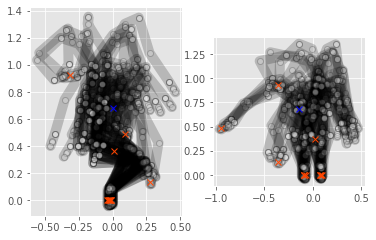

In [26]:
_batch_size = 20
feed_dict={batch_size: _batch_size, eps_var:1.}
feed_dict[batch_target] = get_target_new_batch(_batch_size=int(_batch_size/N_net))

_links, _com , _b_targets = sess.run(
[samples_links, samples_com, batch_target], feed_dict
)

fig, ax = plt.subplots(ncols=2)

for i in range(2):
    dim = [i, 2]
    chain.plot(
            _links, feed_dict={}, ax=ax[i],
            dim=dim, alpha=0.2, color='k'
        )    
    ax[i].plot(_com[0, dim[0]], _com[0, dim[1]], 'bx')
    
    for j, name in enumerate(chain_names):
        ax[i].plot(_b_targets[:, j*3 + dim[0]], _b_targets[:, j*3 + dim[1]], 'rx', color='orangered')

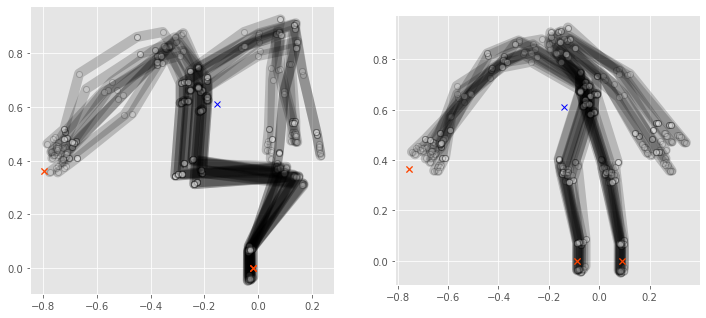

In [27]:
from_dataset = 0
n = 10

_targets_m = np.concatenate([ee[name][:3] for name in chain_names], 0) # mean target
_targets_v = np.array([0.6] * 3 + [0.001]*3 + [0.001] * 3  )  # variance

if from_dataset:
    _targets = get_target_batch(cut=10000, _batch_size=1) * np.ones((int(n/N_net), 1))
else:
    _targets = np.random.multivariate_normal(_targets_m, np.diag(_targets_v ** 2), (1, )) * np.ones((int(n/N_net), 1))

feed_dict={batch_size: n, batch_target: _targets, eps_var:1.}


_links, _com , _b_targets, _samples_q = sess.run(
    [samples_links, samples_com, batch_target, samples_q], 
    feed_dict)

fig, ax = plt.subplots(ncols=2, figsize=(12,8))

for i in range(2):
    dim = [i, 2]
    chain.plot(
            _links, feed_dict={}, ax=ax[i],
            dim=dim, alpha=0.2, color='k'
        )    
    
    for j, name in enumerate(chain_names):
        ax[i].plot(_b_targets[:, j*3 + dim[0]], _b_targets[:, j*3 + dim[1]], 'rx', color='orangered')
    ax[i].plot(_com[0, dim[0]], _com[0, dim[1]], 'bx')
    #ax[i].set_xlim([-.7, .7])
    #x[i].set_ylim([-0.1, 1.2])
plt.savefig('data/talos_config.png')
plt.show()  


## Part 2: Use GAN for Projection, IK and Inverse Kinematics

### Setup Pybullet

In [28]:
import pybullet as p
import pybullet_data
from utils import *
from scipy.optimize import fmin_bfgs
from costs import *
from robot import *
from scipy.optimize import fmin_bfgs
from functools import partial

In [29]:
physics_client_id = p.connect(p.DIRECT)

p.setPhysicsEngineParameter(enableFileCaching=0)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.configureDebugVisualizer(p.COV_ENABLE_GUI,0)

In [126]:
p.resetSimulation()

#### Load in pybullet

In [127]:
#load robot
robot_urdf = rl.datapath + '/urdf/talos_reduced.urdf';
robot_id = p.loadURDF(fileName=robot_urdf)
dof = p.getNumJoints(robot_id)

#load plane
plane_id = p.loadURDF('plane.urdf')
p.resetBasePositionAndOrientation(plane_id, (0,0,0), np.array([0,0,0,1]))

#set default visualization function
set_q_std = partial(set_q,robot_id, pb_joint_indices, set_base=True)
set_q_std(q0Complete)
vis_traj_std = partial(vis_traj, vis_func = set_q_std)

In [128]:
_,_, ball_id = create_primitives(radius = 0.1)

#### Setup the environment

In [129]:
task = 2 #choose 1, 2 or 3
brown_color = (165./255, 42/255., 42/255.,1.)
brown2_color = (165./255, 65/255., 65/255.,1.)
purple_color = (165./255, 100/255., 255/255.,.9)
ori = (0,0,0,1)

if task == 1:
    #task 1
    _,_, box_id = create_primitives(shapeType=p.GEOM_BOX, halfExtents=[0.25, 0.4, 0.03], pos = [0.7,0,.95], rgbaColor=brown_color)
    col_ids = [plane_id, box_id]
elif task == 2:
    #task 2
    _,_, box_id = create_primitives(shapeType=p.GEOM_BOX, halfExtents=[0.25, 0.4, 0.03], pos= [0.55,0,.8], rgbaColor=brown_color)
    _,_, box_id2 = create_primitives(shapeType=p.GEOM_BOX, halfExtents=[0.03, 0.4, 0.12], pos = [0.33,0,.95],  rgbaColor=brown2_color)
    col_ids = [plane_id, box_id, box_id2]
elif task == 3:
        #task3
    _,_, box_id =  create_primitives(shapeType=p.GEOM_BOX, halfExtents=[0.25, 0.4, 0.03], pos = [0.7,0,.75], rgbaColor=brown_color)
    _,_, box_id2 = create_primitives(shapeType=p.GEOM_BOX, halfExtents=[0.03, 0.4, 0.03], pos = [0.5,0,1.22], rgbaColor=purple_color)
    _,_, box_id3 = create_primitives(shapeType=p.GEOM_BOX, halfExtents=[0.03, 0.03, 0.25], pos = [0.5,0.3,1.], rgbaColor=purple_color)
    _,_, box_id4 = create_primitives(shapeType=p.GEOM_BOX, halfExtents=[0.03, 0.03, 0.25], pos = [0.5,-0.3,1.], rgbaColor=purple_color)
    _,_, box_id5 = create_primitives(shapeType=p.GEOM_BOX, halfExtents=[0.03, 0.03, 0.35], pos = [0.5,0.3,0.4], rgbaColor=brown_color)
    _,_, box_id6 = create_primitives(shapeType=p.GEOM_BOX, halfExtents=[0.03, 0.03, 0.35], pos = [0.5,-0.3,.4], rgbaColor=brown_color)
    _,_, box_id7 = create_primitives(shapeType=p.GEOM_BOX, halfExtents=[0.03, 0.03, 0.35], pos = [0.9,0.3,0.4], rgbaColor=brown_color)
    _,_, box_id8 = create_primitives(shapeType=p.GEOM_BOX, halfExtents=[0.03, 0.03, 0.35], pos = [0.9,-0.3,.4], rgbaColor=brown_color)
    col_ids = [plane_id, box_id, box_id2, box_id3, box_id4, box_id5, box_id6]

#### Define frame indices

In [130]:
pb_frame_names = [p.getJointInfo(robot_id,i)[1] for i in range(dof)]

In [131]:
pb_lh_frame_id = pb_frame_names.index(b'gripper_left_joint')
pb_rh_frame_id = pb_frame_names.index(b'gripper_right_joint')
pb_lf_frame_id = pb_frame_names.index(b'leg_left_sole_fix_joint')
pb_rf_frame_id = pb_frame_names.index(b'leg_right_sole_fix_joint')

#### Load from pinocchio

In [132]:
robot_urdf = rl.datapath + '/urdf/talos_reduced.urdf';
rmodel = pin.buildModelFromUrdf(robot_urdf , pin.JointModelFreeFlyer())
rdata = rmodel.createData()

robot_joint_limits = np.vstack([rmodel.lowerPositionLimit, rmodel.upperPositionLimit])

pin_frame_names = [f.name for f in rmodel.frames]
lh_frame_id = rmodel.getFrameId('gripper_left_joint')
rh_frame_id = rmodel.getFrameId('gripper_right_joint')
lf_frame_id = rmodel.getFrameId('leg_left_sole_fix_joint')
rf_frame_id = rmodel.getFrameId('leg_right_sole_fix_joint')

#### Define target poses

In [133]:
#left foot
pos_lf, ori_lf = computePose(rmodel,rdata,lf_frame_id,q0Complete)
rpy_lf = mat2euler(ori_lf)
pose_lf_ref = np.concatenate([pos_lf, rpy_lf])
#right foot
pos_rf, ori_rf = computePose(rmodel,rdata,rf_frame_id,q0Complete)
rpy_rf = mat2euler(ori_rf)
pose_rf_ref = np.concatenate([pos_rf, rpy_rf])
#left hand
pos_lh, ori_lh = computePose(rmodel,rdata,lh_frame_id,q0Complete)
pose_lh_ref = np.concatenate([np.array([0.3,0.2, 0.4]), np.array([0,-np.pi/2,0.])])
#right hand
pos_rh, ori_rh = computePose(rmodel,rdata,rh_frame_id,q0Complete)
rpy_rh = mat2euler(ori_rh)
pose_rh_ref = np.concatenate([pos_rh, rpy_rh])

### Define Projector & IK solver

In [134]:
lf_cost = CostFrameRPYFloatingBase(rmodel, rdata, pose_lf_ref,lf_frame_id, sel_vector=np.array([1,1,1,1,1,1]))
rf_cost = CostFrameRPYFloatingBase(rmodel, rdata, pose_rf_ref,rf_frame_id, sel_vector=np.array([1,1,1,1,1,1]))
bound_cost = CostBound(robot_joint_limits)
posture_cost = CostPosture(rmodel, rdata, q0Complete)
com_bounds = np.array([[-0.1,-0.1,0.6],[0.1, 0.1, 1.1]])
cost_com_bounds = CostCOMBounds(rmodel, rdata, com_bounds)
cost_sum = CostSum()

cost_sum.addCost(lf_cost, 20., 'lf_pose', 1e-5)
cost_sum.addCost(rf_cost, 20.,'rf_pose', 1e-5)
cost_sum.addCost(bound_cost, 10., 'com_limit', 1e-4)
cost_sum.addCost(cost_com_bounds, 10., 'joint_limit', 1e-4)
cost_sum.addCost(posture_cost, .01, 'posture', 1e3)

robot_projector_old = TalosCostProjector(cost_sum)


rh_cost = CostFrameRPYFloatingBase(rmodel, rdata, pose_rh_ref,rh_frame_id, sel_vector=np.array([1,1,1,0,0,0]))

cost_sum2 = CostSum()
cost_sum2.addCost(rh_cost, 20., 'rh_pose', 1e-3)
cost_sum2.addCost(lf_cost, 20., 'lf_pose', 1e-5)
cost_sum2.addCost(rf_cost, 20.,'rf_pose', 1e-5)
cost_sum2.addCost(bound_cost, 10., 'com_limit', 1e-4)
cost_sum2.addCost(cost_com_bounds, 10., 'joint_limit', 1e-4)
cost_sum2.addCost(posture_cost, .01, 'posture', 1e3)

robot_ik_solver_old = TalosCostProjector(cost_sum2)

### Define new projector & IK solver

#### Define target poses

In [135]:
for i in range(robot_joint_limits.shape[0]):
    for j in range(robot_joint_limits.shape[1]):
        if robot_joint_limits[i,j] < -1e10: robot_joint_limits[i,j] = -1e10
        if robot_joint_limits[i,j] > 1e10: robot_joint_limits[i,j] = 1e10

In [136]:
from costs_pseudo import *

In [137]:
#left foot
w_lf = mat2w(ori_lf)
pose_lf_ref_new = pin.SE3(ori_lf, pos_lf)
#right foot
w_rf = mat2w(ori_rf)
pose_rf_ref_new = pin.SE3(ori_rf, pos_rf)
#right hand
w_rh = mat2w(ori_rh)
pose_rh_ref_new = pos_rh

In [138]:
# lf_cost_new = CostFrameRPYFloatingBaseNew(rmodel, rdata, pose_lf_ref,lf_frame_id, sel_vector=np.array([1,1,1,1,1,1]))
# rf_cost_new = CostFrameRPYFloatingBaseNew(rmodel, rdata, pose_rf_ref,rf_frame_id, sel_vector=np.array([1,1,1,1,1,1]))
# rh_cost_new = CostFrameTranslationFloatingBaseNew(rmodel, rdata, pose_rh_ref[:3],rh_frame_id, weight=np.array([1,1,1]))
lf_cost_new = CostFrameSE3FloatingBaseNew(rmodel, rdata, pose_lf_ref_new,lf_frame_id, weight=np.array([1.,1.,1.,1.,1.,1.]))
rf_cost_new = CostFrameSE3FloatingBaseNew(rmodel, rdata, pose_rf_ref_new,rf_frame_id, weight=np.array([1.,1.,1.,1.,1.,1.]))
rh_cost_new = CostFrameTranslationFloatingBaseNew(rmodel, rdata, pose_rh_ref_new,rh_frame_id, weight=np.array([1.,1.,1.]))
cost_com_bounds_new = CostCOMBoundsNew(rmodel, rdata, com_bounds, 1e-4)
bound_cost_new = CostBoundFloatingBaseNew(robot_joint_limits, 1e-4)
posture_weights = np.ones(34) 
posture_weights[3:6] *= 10
posture_cost_new = CostPostureNew(rmodel, rdata, q0Complete, weights = posture_weights)

In [139]:
cost_sum_new = CostSumNew(rmodel, rdata)
cost_sum_new2 = CostSumNew(rmodel, rdata)
cost_sum_new_ik = CostSumNew(rmodel, rdata)

In [140]:
cost_sum_new_ik.addCost(lf_cost_new, 20., 'lf_pose', 1e-4)
cost_sum_new_ik.addCost(rf_cost_new, 20.,'rf_pose', 1e-4)
cost_sum_new_ik.addCost(cost_com_bounds_new, 20., 'com_limit', 1e-3)
cost_sum_new_ik.addCost(bound_cost_new, 20., 'joint_limit', 1e-3)
cost_sum_new_ik.addCost(rh_cost_new, 20.,'rh_pose', 1e-3)

In [141]:
cost_sum_new.addCost(lf_cost_new, 20., 'lf_pose', 1e-4)
cost_sum_new.addCost(rf_cost_new, 20.,'rf_pose', 1e-4)
cost_sum_new.addCost(cost_com_bounds_new, 20., 'com_limit', 1e-3)
cost_sum_new.addCost(bound_cost_new, 20., 'joint_limit', 1e-3)

In [142]:
cost_sum_new2.addCost(posture_cost_new, 1. , 'posture', 1e3)

In [143]:
robot_projector = TalosCostProjectorNew(cost_sum_new, rmodel, rdata, cost2 = cost_sum_new2, bounds = robot_joint_limits)

robot_ik_solver = TalosCostProjectorNew(cost_sum_new_ik, rmodel, rdata, cost2 = cost_sum_new2, bounds = robot_joint_limits)

#### Using GAN sampler

In [144]:
class GANSampler():
    def __init__(self, target_sampler):
        self.target_sampler = target_sampler
        self.name = 'GAN'
    
    def sample(self,N = 1, _poses = None, var = 1., idx_input = None):
        if _poses is None:
            _poses = self.target_sampler.sample(N)
        self.poses = _poses
        _foot_poses = np.tile(np.concatenate([pose_rf_ref[:3], pose_lf_ref[:3]]), (N,1))
        _targets = np.hstack([_poses, _foot_poses])
        feed_dict={batch_size: N*N_net, batch_target: _targets, eps_var:var}
        feed_dict[batch_foot_ori] = _batch_foot_ori

        _samples_q = sess.run([samples_q],feed_dict)
        _samples_q = _samples_q[0]
        qnew = []
        for i in range(N):
            #samples from N_net networks
            if idx_input is None:
                idx = np.random.randint(N_net)
            else:
                idx = idx_input
            q = _samples_q[idx*N + i]
            qnew += [get_pb_config(q)]
        return np.array(qnew)

In [145]:
#define standard sampler
base_sampler = sampler(com_bounds.copy())
joint_sampler = sampler(robot_joint_limits[:,7:])
rob_sampler = talos_sampler(base_sampler, np.array([0,0,0,1]), joint_sampler, q0Complete)

#define GAN sampler
target_bounds = np.array([[-0.6, -.6, 0.3], [0.8, .6, 1.4]])
#target_bounds = np.array([[0.2, -.6, 0.3], [0.8, .6, 1.4]])
target_sampler = sampler( target_bounds)
gan_sampler = GANSampler(target_sampler)

#### Try GAN sampler


In [146]:
#q = gan_sampler.sample(_poses = np.array([[-0.2, -0.3, 1.]]))[0]
q = gan_sampler.sample()[0]
set_q_std(q)

#### Compare the projector

In [148]:
robot_projector.mu = 1e-4
robot_projector.mu_ext = 1e-6
robot_projector.alpha2 = 1.

robot_projector.alpha_fac = 0.2

In [149]:
methods = [rob_sampler, gan_sampler]
method_names = ['Random', 'GAN']
# methods = [gan_sampler]
# method_names = [ 'GAN']
samples = gan_sampler.sample(5000)

N = 500

data = dict()
for m in range(len(methods)):
    comp_times = []
    success = []
    fevals = []
    qs = []
    for i in range(N):
        #idx = np.random.randint(500)
        idx = i
        if method_names[m] == 'GAN':
            q = samples[idx]
        else:
            q = rob_sampler.sample().flatten()
        tic = time.time()
        res = robot_projector.project(q)
        toc = time.time()
        comp_times += [toc-tic]
        success += [res['stat']]
        fevals += [res['nfev']]
        qs += [res['q']]
#         if res['stat'] is False:
#             print('fail')
#             break
    data[method_names[m]] = [comp_times, success, fevals, qs]

In [150]:
for m in range(len(methods[:2])):
    print('& ' + method_names[m], end=' ')
    comp_times, success, fevals, qs = data[method_names[m]]
    comp_times = np.array(comp_times)
    fevals = np.array(fevals)

    print('& {0:.1f} &  {1:.1f} $\pm$ {2:.1f} &  {3:.1f} $\pm$ {4:.1f} &  {5:.1f} $\pm$ {6:.1f}'.format(np.sum(success)*100./N, np.mean(comp_times)*1000, np.std(comp_times)*1000, np.mean(comp_times[success])*1000, np.std(comp_times[success])*1000,np.mean(fevals[success]), np.std(fevals[success])), end = ''),
    print('\\\\ ')

& Random & 83.2 &  40.0 $\pm$ 48.3 &  20.2 $\pm$ 18.5 &  9.0 $\pm$ 7.4\\ 
& GAN & 100.0 &  4.2 $\pm$ 2.5 &  4.2 $\pm$ 2.5 &  2.2 $\pm$ 1.1\\ 


### Compare the IK solver

In [151]:
ik_target_bounds = np.array([[0.3, -.4, 0.6], [0.8, .4, 1.1]])
#target_bounds = np.array([[0.2, -.6, 0.3], [0.8, .6, 1.4]])
ik_target_sampler = sampler( ik_target_bounds)

In [152]:
robot_ik_solver.mu = 1e-4
robot_ik_solver.mu_ext = 1e-6
robot_ik_solver.alpha2 = 1
robot_ik_solver.alpha_fac = 0.2

In [153]:
#targets = data_target[:2000,:3]
targets = ik_target_sampler.sample(2000)
samples = gan_sampler.sample(N=2000, _poses=targets, var = 0.1)

In [154]:
methods = [rob_sampler, gan_sampler]
method_names = ['Random', 'GAN']
# methods = [rob_sampler]
# method_names = [ 'Random']
# methods = [gan_sampler]
# method_names = [ 'GAN']

N = 500
data = dict()
for m in range(len(methods)):
    comp_times = []
    success = []
    fevals = []
    for i in range(N):
        idx = i
        if method_names[m] == 'GAN':
            q = samples[idx]
        else:
            q = rob_sampler.sample().flatten()
        tic = time.time()
        robot_ik_solver.cost.costs['rh_pose'].cost.desired_pose[:3] = targets[i]
        res = robot_ik_solver.project(q)
        toc = time.time()
        comp_times += [toc-tic]
        success += [res['stat']]
        fevals += [res['nfev']]
        data[method_names[m]] = [comp_times, success, fevals]
clear_output()

In [155]:
for m in range(len(methods[:2])):
    print('& ' + method_names[m], end=' ')
    comp_times, success, fevals = data[method_names[m]]
    comp_times = np.array(comp_times)
    fevals = np.array(fevals)

    print('& {0:.1f} &  {1:.1f} $\pm$ {2:.1f} &  {3:.1f} $\pm$ {4:.1f} &  {5:.1f} $\pm$ {6:.1f}'.format(np.sum(success)*100./N, np.mean(comp_times)*1000, np.std(comp_times)*1000, np.mean(comp_times[success])*1000, np.std(comp_times[success])*1000,np.mean(fevals[success]), np.std(fevals[success])), end = ''),
    print('\\\\ ')

& Random & 82.6 &  47.7 $\pm$ 50.4 &  27.1 $\pm$ 23.4 &  10.8 $\pm$ 8.4\\ 
& GAN & 100.0 &  4.9 $\pm$ 1.2 &  4.9 $\pm$ 1.2 &  2.5 $\pm$ 0.6\\ 


In [156]:
for m in range(len(methods[:2])):
    print('& ' + method_names[m], end=' ')
    comp_times, success, fevals = data[method_names[m]]
    comp_times = np.array(comp_times)
    fevals = np.array(fevals)

    print('& {0:.1f} &  {1:.1f} $\pm$ {2:.1f} &  {3:.1f} $\pm$ {4:.1f} &  {5:.1f} $\pm$ {6:.1f}'.format(np.sum(success)*100./N, np.mean(comp_times)*1000, np.std(comp_times)*1000, np.mean(comp_times[success])*1000, np.std(comp_times[success])*1000,np.mean(fevals[success]), np.std(fevals[success])), end = ''),
    print('\\\\ ')

& Random & 82.6 &  47.7 $\pm$ 50.4 &  27.1 $\pm$ 23.4 &  10.8 $\pm$ 8.4\\ 
& GAN & 100.0 &  4.9 $\pm$ 1.2 &  4.9 $\pm$ 1.2 &  2.5 $\pm$ 0.6\\ 


***

## c-RRT with Talos

In [157]:
rob_col_checker = col_checker(robot_id, pb_joint_indices, col_ids, omit_indices=[ 50, 57], floating_base = True) #omit the collision of the plane with the feet
rob_interpolator = interpolator()

In [158]:
rrt = cRRT(rmodel.nq, rob_sampler, rob_col_checker, rob_interpolator, robot_projector)

ganrrt = cRRT(rmodel.nq, gan_sampler, rob_col_checker, rob_interpolator, robot_projector)

hybrid_sampler = HybridSampler(rob_sampler, gan_sampler, p_random=0.2)
hybridrrt = cRRT(rmodel.nq, hybrid_sampler, rob_col_checker, rob_interpolator, robot_projector)

In [159]:
rrt_old = cRRT(rmodel.nq, rob_sampler, rob_col_checker, rob_interpolator, robot_projector_old)

ganrrt_old = cRRT(rmodel.nq, gan_sampler, rob_col_checker, rob_interpolator, robot_projector_old)

# hybrid_sampler = HybridSampler(rob_sampler, gan_sampler, p_random=0.2)
# hybridrrt = cRRT(rmodel.nq, hybrid_sampler, rob_col_checker, rob_interpolator, robot_projector)

#### Get initial state

In [160]:
if task == 1:
    #Task 1
    init_bounds = np.array([[0.55, -0.25, 1.1], [0.85, 0.25, 1.3]])
    goal_bounds = np.array([[0.55, -0.25, .4], [0.85, 0.25, .8]])
elif task == 2:
    init_bounds = np.array([[0.3, -0.25, 1.], [0.7, 0.25, 1.3]])
    goal_bounds = np.array([[0.3, -0.25, .4], [0.7, 0.25, .8]])
elif task == 3:
    init_bounds = np.array([[0.55, -0.2, .8], [0.7, 0.2, 1.1]])
    goal_bounds = np.array([[0.55, -0.2, .4], [0.7, 0.2, .6]])
init_sampler = sampler(init_bounds)
goal_sampler = sampler(goal_bounds)

#### Try sampling the tasks

#### Sample initial and goal configurations

In [161]:
def get_valid_config(pos_sampler, goal_pose = None, max_try = 50):
    is_collide = True
    status = False
    i = 0
    while is_collide or status is False and i < max_try:
        i+=1
        if goal_pose is None: 
            goal_pos = pos_sampler.sample()
        else:
            goal_pos = goal_pose.copy()
        #goal_pos = np.array([0.6, -0.1, .9])[None,:]
        #sample = gan_sampler.sample(_poses=goal_pos, var=1.)[0]
        sample = rob_sampler.sample()[0]
        set_q_std(sample)
        rh_cost_new.desired_pose[:3] = goal_pos[0]
        rh_cost.desired_pose[:3] = goal_pos[0]
        res = robot_ik_solver.project(sample.flatten())
        start_state = res['q']
        status = res['stat']
        is_collide = rob_col_checker.check_collision(start_state.flatten())
            
            
    set_q_std(start_state)
    clear_output()
    return start_state, goal_pos

def get_multiple_configs(pos_sampler, N = 1, R = 1):
    samples_set = []
    for i in range(N):
        print(i)
        sample, goal_pos = get_valid_config(pos_sampler)
        samples = [sample]
        for j in range(R-1):
            sample, goal_pos = get_valid_config(pos_sampler, goal_pos)
            samples += [sample]
        samples_set += [samples]
    clear_output()
    return samples_set

In [162]:
is_generate_data = True
N = 50 #number of initial configurations
N_goal = 5
K = 10 #number of goal configurations per task

if is_generate_data:
    init_configs = get_multiple_configs(init_sampler, N = N)
    goal_configs = get_multiple_configs(goal_sampler, N = N_goal, R = K)

    data_configs = dict()
    data_configs['init'] = init_configs
    data_configs['goal'] = goal_configs
    np.save('data/task1' + str(task) + '_configs.npy', data_configs)
else:
    data_configs = np.load('data/task1' + str(task) + '_configs.npy', allow_pickle=True).tolist()
    init_configs = data_configs['init']
    goal_configs = data_configs['goal']

'''
for qs in init_configs:
    for q in qs:
        set_q_std(q)
        input()
clear_output()

for qs in goal_configs:
    for q in qs:
        set_q_std(q)
        input()
clear_output()
'''


'\nfor qs in init_configs:\n    for q in qs:\n        set_q_std(q)\n        input()\nclear_output()\n\nfor qs in goal_configs:\n    for q in qs:\n        set_q_std(q)\n        input()\nclear_output()\n'

## Planning comparison

In [163]:
robot_projector.mu = 1e-4

In [164]:
robot_projector.alpha2 = 1

In [165]:
gan_result = dict()
std_result = dict()
hybrid_result = dict()
results = [gan_result, std_result, hybrid_result]
for result in results:
    result['comp_times'] = []
    result['nfevs'] = []
    result['retry'] = []
    result['nexts'] = []
    result['success'] = []
    result['path'] = []

i=0

In [166]:
goal_indices = np.random.randint(N_goal, size = N)

In [167]:
rob_sampler.name = 'GAN'

In [168]:
hybrid_sampler.p_random = 0.2

In [169]:
for i,qs in enumerate(init_configs[:]):
    start_state = qs[0]
    goal_states = goal_configs[goal_indices[i]]

    print('Plan RRT')
    print(i, np.mean(std_result['comp_times']), np.mean(gan_result['comp_times']), np.mean(hybrid_result['comp_times']))
    print(i, np.sum(std_result['success']), np.sum(gan_result['success']), np.sum(hybrid_result['success']))      

#         #plan using crrt
    path, nfevs, nexts, success, retry, t  = rrt.plan(start_state,goal_states, max_extension_steps=500)
    clear_output()
    std_result['comp_times'] += [t]
    std_result['nfevs'] += [nfevs]
    std_result['retry'] += [retry]
    std_result['nexts'] += [nexts]
    std_result['success'] += [success]
    std_result['path'] += [path]

    print('Plan GAN RRT')
    print(i, np.mean(std_result['comp_times']), np.mean(gan_result['comp_times']), np.mean(hybrid_result['comp_times']))
    print(i, np.sum(std_result['success']), np.sum(gan_result['success']), np.sum(hybrid_result['success']))      

#         #plan using ganrrt
    path, nfevs, nexts, success, retry, t  = ganrrt.plan(start_state,goal_states, max_extension_steps=500, n_retry=5)
    clear_output()
    gan_result['comp_times'] += [t]
    gan_result['nfevs'] += [nfevs]
    gan_result['retry'] += [retry]
    gan_result['nexts'] += [nexts]
    gan_result['success'] += [success]
    gan_result['path'] += [path]

    print('Plan Hybrid RRT')
    print(i, np.mean(std_result['comp_times']), np.mean(gan_result['comp_times']), np.mean(hybrid_result['comp_times']))
    print(i, np.sum(std_result['success']), np.sum(gan_result['success']), np.sum(hybrid_result['success']))      
#         #plan using hybridrrt
    path, nfevs, nexts, success, retry, t  = hybridrrt.plan(start_state,goal_states, max_extension_steps=500)
    clear_output()
    hybrid_result['comp_times'] += [t]
    hybrid_result['nfevs'] += [nfevs]
    hybrid_result['retry'] += [retry]
    hybrid_result['nexts'] += [nexts]
    hybrid_result['success'] += [success]
    hybrid_result['path'] += [path]

    if i % 20 == 0:
        data = dict()
        data['random'] = std_result
        data['gan'] = gan_result
        data['hybrid'] = hybrid_result
        np.save('data/task3_temp.npy', data)

In [170]:
print('& Random & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(std_result['success'])*100./len(std_result['success']), np.mean(std_result['comp_times']), np.std(std_result['comp_times']), np.mean(std_result['nfevs']), np.std(std_result['nfevs']), np.mean(std_result['nexts']), np.std(std_result['nexts'])))

print('& GAN & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(gan_result['success'])*100./len(gan_result['success']), np.mean(gan_result['comp_times']), np.std(gan_result['comp_times']), np.mean(gan_result['nfevs']), np.std(gan_result['nfevs']), np.mean(gan_result['nexts']), np.std(gan_result['nexts'])))

print('& Hybrid & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(hybrid_result['success'])*100./len(hybrid_result['success']), np.mean(hybrid_result['comp_times']), np.std(hybrid_result['comp_times']), np.mean(hybrid_result['nfevs']), np.std(hybrid_result['nfevs']), np.mean(hybrid_result['nexts']), np.std(hybrid_result['nexts'])))

& Random & 100.0 & 1.07 $\pm$ 0.81 & 389.5 $\pm$ 302.0 & 17.6 $\pm$ 13.0 \\
& GAN & 100.0 & 0.62 $\pm$ 0.42 & 138.9 $\pm$ 91.2 & 39.7 $\pm$ 34.7 \\
& Hybrid & 100.0 & 0.57 $\pm$ 0.39 & 159.8 $\pm$ 110.3 & 24.8 $\pm$ 20.2 \\


In [125]:
print('& Random & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(std_result['success'])*100./len(std_result['success']), np.mean(std_result['comp_times']), np.std(std_result['comp_times']), np.mean(std_result['nfevs']), np.std(std_result['nfevs']), np.mean(std_result['nexts']), np.std(std_result['nexts'])))

print('& GAN & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(gan_result['success'])*100./len(gan_result['success']), np.mean(gan_result['comp_times']), np.std(gan_result['comp_times']), np.mean(gan_result['nfevs']), np.std(gan_result['nfevs']), np.mean(gan_result['nexts']), np.std(gan_result['nexts'])))

print('& Hybrid & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(hybrid_result['success'])*100./len(hybrid_result['success']), np.mean(hybrid_result['comp_times']), np.std(hybrid_result['comp_times']), np.mean(hybrid_result['nfevs']), np.std(hybrid_result['nfevs']), np.mean(hybrid_result['nexts']), np.std(hybrid_result['nexts'])))

& Random & 100.0 & 1.20 $\pm$ 0.99 & 464.4 $\pm$ 390.7 & 16.2 $\pm$ 12.4 \\
& GAN & 100.0 & 0.28 $\pm$ 0.13 & 74.0 $\pm$ 34.3 & 10.2 $\pm$ 7.3 \\
& Hybrid & 100.0 & 0.43 $\pm$ 0.25 & 131.4 $\pm$ 80.0 & 13.5 $\pm$ 10.0 \\


In [74]:
print('& Random & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(std_result['success'])*100./len(std_result['success']), np.mean(std_result['comp_times']), np.std(std_result['comp_times']), np.mean(std_result['nfevs']), np.std(std_result['nfevs']), np.mean(std_result['nexts']), np.std(std_result['nexts'])))

print('& GAN & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(gan_result['success'])*100./len(gan_result['success']), np.mean(gan_result['comp_times']), np.std(gan_result['comp_times']), np.mean(gan_result['nfevs']), np.std(gan_result['nfevs']), np.mean(gan_result['nexts']), np.std(gan_result['nexts'])))

print('& Hybrid & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(hybrid_result['success'])*100./len(hybrid_result['success']), np.mean(hybrid_result['comp_times']), np.std(hybrid_result['comp_times']), np.mean(hybrid_result['nfevs']), np.std(hybrid_result['nfevs']), np.mean(hybrid_result['nexts']), np.std(hybrid_result['nexts'])))

& Random & nan & nan $\pm$ nan & nan $\pm$ nan & nan $\pm$ nan \\
& GAN & 100.0 & 1.00 $\pm$ 1.46 & 161.5 $\pm$ 228.4 & 53.1 $\pm$ 145.1 \\
& Hybrid & 100.0 & 0.95 $\pm$ 0.58 & 184.2 $\pm$ 118.0 & 32.4 $\pm$ 27.0 \\


<ipython-input-74-45d91c711ad4>:1: RuntimeWarning: invalid value encountered in double_scalars
  print('& Random & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(std_result['success'])*100./len(std_result['success']), np.mean(std_result['comp_times']), np.std(std_result['comp_times']), np.mean(std_result['nfevs']), np.std(std_result['nfevs']), np.mean(std_result['nexts']), np.std(std_result['nexts'])))
/home/teguh/miniconda3/envs/tf3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/teguh/miniconda3/envs/tf3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/teguh/miniconda3/envs/tf3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type

In [78]:
print('& Random & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(std_result['success'])*100./len(std_result['success']), np.mean(std_result['comp_times']), np.std(std_result['comp_times']), np.mean(std_result['nfevs']), np.std(std_result['nfevs']), np.mean(std_result['nexts']), np.std(std_result['nexts'])))

print('& GAN & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(gan_result['success'])*100./len(gan_result['success']), np.mean(gan_result['comp_times']), np.std(gan_result['comp_times']), np.mean(gan_result['nfevs']), np.std(gan_result['nfevs']), np.mean(gan_result['nexts']), np.std(gan_result['nexts'])))

print('& Hybrid & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(hybrid_result['success'])*100./len(hybrid_result['success']), np.mean(hybrid_result['comp_times']), np.std(hybrid_result['comp_times']), np.mean(hybrid_result['nfevs']), np.std(hybrid_result['nfevs']), np.mean(hybrid_result['nexts']), np.std(hybrid_result['nexts'])))

& Random & nan & nan $\pm$ nan & nan $\pm$ nan & nan $\pm$ nan \\
& GAN & 100.0 & 0.97 $\pm$ 1.43 & 174.5 $\pm$ 231.6 & 59.3 $\pm$ 166.0 \\
& Hybrid & 100.0 & 1.00 $\pm$ 0.68 & 233.7 $\pm$ 173.9 & 39.0 $\pm$ 28.5 \\


<ipython-input-78-45d91c711ad4>:1: RuntimeWarning: invalid value encountered in double_scalars
  print('& Random & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(std_result['success'])*100./len(std_result['success']), np.mean(std_result['comp_times']), np.std(std_result['comp_times']), np.mean(std_result['nfevs']), np.std(std_result['nfevs']), np.mean(std_result['nexts']), np.std(std_result['nexts'])))
/home/teguh/miniconda3/envs/tf3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/teguh/miniconda3/envs/tf3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/teguh/miniconda3/envs/tf3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type

In [73]:
print('& Random & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(std_result['success'])*100./len(std_result['success']), np.mean(std_result['comp_times']), np.std(std_result['comp_times']), np.mean(std_result['nfevs']), np.std(std_result['nfevs']), np.mean(std_result['nexts']), np.std(std_result['nexts'])))

print('& GAN & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(gan_result['success'])*100./len(gan_result['success']), np.mean(gan_result['comp_times']), np.std(gan_result['comp_times']), np.mean(gan_result['nfevs']), np.std(gan_result['nfevs']), np.mean(gan_result['nexts']), np.std(gan_result['nexts'])))

print('& Hybrid & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(hybrid_result['success'])*100./len(hybrid_result['success']), np.mean(hybrid_result['comp_times']), np.std(hybrid_result['comp_times']), np.mean(hybrid_result['nfevs']), np.std(hybrid_result['nfevs']), np.mean(hybrid_result['nexts']), np.std(hybrid_result['nexts'])))

& Random & 100.0 & 2.94 $\pm$ 2.58 & 1068.1 $\pm$ 994.7 & 99.1 $\pm$ 77.7 \\
& GAN & 100.0 & 0.81 $\pm$ 0.50 & 153.7 $\pm$ 92.7 & 40.2 $\pm$ 36.8 \\
& Hybrid & 100.0 & 0.88 $\pm$ 0.48 & 204.8 $\pm$ 126.4 & 39.2 $\pm$ 31.8 \\


In [279]:
print('& Random & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(std_result['success'])*100./len(std_result['success']), np.mean(std_result['comp_times']), np.std(std_result['comp_times']), np.mean(std_result['nfevs']), np.std(std_result['nfevs']), np.mean(std_result['nexts']), np.std(std_result['nexts'])))

print('& GAN & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(gan_result['success'])*100./len(gan_result['success']), np.mean(gan_result['comp_times']), np.std(gan_result['comp_times']), np.mean(gan_result['nfevs']), np.std(gan_result['nfevs']), np.mean(gan_result['nexts']), np.std(gan_result['nexts'])))

print('& Hybrid & {0:.1f} & {1:.2f} $\pm$ {2:.2f} & {3:.1f} $\pm$ {4:.1f} & {5:.1f} $\pm$ {6:.1f} \\\\'.format(np.sum(hybrid_result['success'])*100./len(hybrid_result['success']), np.mean(hybrid_result['comp_times']), np.std(hybrid_result['comp_times']), np.mean(hybrid_result['nfevs']), np.std(hybrid_result['nfevs']), np.mean(hybrid_result['nexts']), np.std(hybrid_result['nexts'])))

& Random & 100.0 & 1.91 $\pm$ 1.40 & 829.8 $\pm$ 647.6 & 84.2 $\pm$ 71.7 \\
& GAN & 100.0 & 0.60 $\pm$ 0.75 & 136.5 $\pm$ 168.1 & 44.1 $\pm$ 115.7 \\
& Hybrid & 100.0 & 1.04 $\pm$ 2.25 & 280.5 $\pm$ 683.7 & 67.7 $\pm$ 210.1 \\


In [513]:
trajs = gan_result['path']

In [516]:
vis_traj_std(trajs[2])

In [ ]:
data = dict()
data['random'] = std_result
data['gan'] = gan_result
data['hybrid'] = hybrid_result
np.save('data/task' + str(task) + '3.npy', data)

## Test one by one

In [1584]:
robot_projector.alpha2 = 0.01

In [1356]:
cost_com_bounds_new.margin = 1e-12

In [1357]:
bound_cost_new.margin = 1e-12

In [1201]:
q = rrt.sample(False)[0]
set_q_std(q)

In [1558]:
path, nfevs, nexts, success, retry, t  = rrt.plan(start_state,goal_states, max_extension_steps=500)


Solution found!


In [1281]:
path, nfevs, nexts, success, retry, t  = ganrrt.plan(start_state,goal_states, max_extension_steps=500)


Solution found!


In [760]:
path, nfevs, nexts, success, retry, t  = ganrrt_old.plan(start_state,goal_states, max_extension_steps=500)


Solution found!


In [256]:
sel_rrt = ganrrt

In [257]:
set_q_std(start_state)

In [258]:
sel_rrt.init_plan(start_state, goal_states)

In [282]:
success = False
# sample random state
nfevs = 0
sel_rrt.random_sample, nfev = sel_rrt.sample(False)
sel_rrt.random_sample = sel_rrt.random_sample.flatten()
nfevs += nfev

In [283]:
set_q_std(sel_rrt.random_sample)

In [284]:
# find a nearest node
nearest_index, nearest_sample = sel_rrt.find_nearest(sel_rrt.random_sample, np.array(sel_rrt.samples))

# extend to the random state
sel_rrt.next_states, nfev = sel_rrt.extend(nearest_index[0], nearest_sample.flatten(), sel_rrt.random_sample.flatten())
nfevs += nfev

q_reach_a = sel_rrt.next_states[-1]

In [285]:
next_states = lin_interpolate(nearest_sample.flatten(), sel_rrt.random_sample.flatten(), 10)

In [286]:
robot_projector.cost2 = cost_sum_new2

In [287]:
qr = next_states[3]
set_q_std(qr)

In [288]:
qn = robot_projector.project(qr)['q']
set_q_std(qn)

In [289]:
qn = robot_projector_old.project(qr)['q']
set_q_std(qn)

In [290]:
np.set_printoptions(precision=4, suppress=True)

In [291]:
vis_traj_std(next_states,dt=0.2)

In [293]:
vis_traj_std(sel_rrt.next_states)

In [278]:
set_q_std(start_state)

In [279]:
set_q_std(q_reach_a)

In [280]:
# extend to the goal
# find the nearest goal
nearest_index, nearest_sample = sel_rrt.find_nearest(q_reach_a, np.array(sel_rrt.goal_state))
q_goal = nearest_sample.flatten()

sel_rrt.next_states_goal, nfev = sel_rrt.extend(len(sel_rrt.samples) - 1, sel_rrt.next_states[-1], q_goal)
sel_rrt.q_goal = q_goal
nfevs += nfev

if np.linalg.norm(sel_rrt.next_states_goal[-1] - q_goal) < 0.001:
    print('Solution is found!')
    success = True

In [281]:
set_q_std(sel_rrt.next_states_goal[0])

#### Compare

In [967]:
rob_sampler.q_ref = q0Complete

In [929]:
q = gan_sampler.sample()[0]

In [932]:
set_q_std(q)

In [935]:
q1 = robot_projector_old.project(q)['q']
set_q_std(q1)

In [936]:
q2 = robot_projector.project(q)['q']
set_q_std(q2)

In [987]:
q = rob_sampler.sample()[0]

In [994]:
set_q_std(q)

In [993]:
q1 = robot_projector_old.project(q)['q']
set_q_std(q1)

In [995]:
q2 = robot_projector.project(q)['q']
set_q_std(q2)

In [996]:
np.sum(robot_projector.cost2.calc(q2)**2)

15.88050147469939

In [997]:
posture_cost.calc(q1)

3.2493658646428742